In [3]:
# Add the parent directory to path
import sys

sys.path.append("..")


In [4]:
import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env import Env, Log
from epidemic_env.dynamics import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn

from pathlib import Path

# from tqdm import tqdm

"""Policy imports"""
from utils.utils import simulate_policy

%matplotlib inline


In [5]:
!which python

/Users/mohahf19/micromamba/envs/annrl2023/bin/python


['Lausanne', 'Geneva', 'Sion', 'Neuchâtel', 'Basel', 'Bern', 'Lücern', 'St-Gallen', 'Zürich']


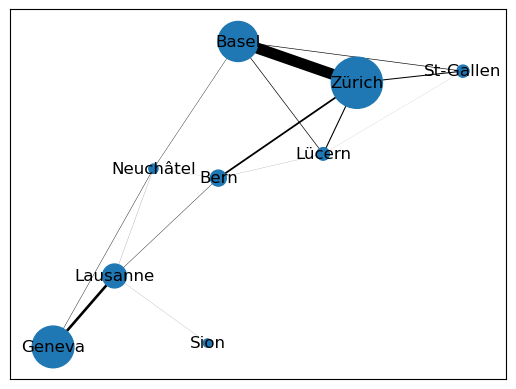

In [6]:
dyn = ModelDynamics("../config/switzerland.yaml")  # load the switzerland map
print(dyn.cities)
dyn.draw_map()


## Preprocessing of action and obseervation spaces


In [15]:
from typing import Callable
from copy import deepcopy

action = {  # DO NOTHING
    "confinement": False,
    "isolation": False,
    "hospital": False,
    "vaccinate": False,
}

# Actually, actions can be any combination of the four.
action_value_dict = {0: "confinement", 1: "isolation", 2: "hospital", 3: "vaccinate"}

# num_actions = 2**1  # If only for confinement
num_actions = 5  # Do nothing and toggle 4 actions
num_cities = len(dyn.cities)
num_features_per_city = 2  # infected, dead

num_observation_features = (
    num_cities * (num_features_per_city * 7) + 4
)  # 4 curr_actions


def observation_to_tensor(
    obs: Observation,
    dyn: ModelDynamics,
    curr_action: dict,
    features_per_city: int = 7 * num_features_per_city,
) -> torch.Tensor:
    """Convers the observation object to a torch Tensor
    The tensor is defined as: for each city, population (1), infected (7), dead (7)
    """
    num_cities = len(dyn.cities)
    output = torch.zeros(num_cities * features_per_city + 4)
    for i, city in enumerate(dyn.cities):
        output[i * features_per_city : i * features_per_city + 7] = (
            torch.tensor(obs.city[city].infected) / obs.pop[city]
        ) ** (1 / 4)
        output[i * features_per_city + 7 : i * features_per_city + 14] = (
            torch.tensor(obs.city[city].dead) / obs.pop[city]
        ) ** (1 / 4)

    # Add the current action to the observation
    output[-4] = int(curr_action["confinement"])
    output[-3] = int(curr_action["isolation"])
    output[-2] = int(curr_action["hospital"])
    output[-1] = int(curr_action["vaccinate"])

    return output


"""Loading the environment"""
env = Env(
    dyn,  # We pass the dynamical model to the environment
    action_space=spaces.Discrete(
        num_actions
    ),  # Here one could pass an openai gym action space that can then be sampled
    observation_space=spaces.Box(
        low=0, high=np.inf, shape=(num_observation_features,), dtype=float
    ),  # Here one could pass an openai gym obs space that can then be sampled
)


def action_value_to_actions(action_value: int, curr_action: dict) -> list[int]:
    if action_value == 0:
        return []
    str_action = action_value_dict[action_value - 1]

    return [str_action]


def create_action(
    action: int,
    curr_action: dict,
    action_value_to_actions: Callable = action_value_to_actions,
    action_value_dict: dict = action_value_dict,
) -> dict[str, bool]:
    """Creates a policy from the encoded action value"""
    created_actions = action_value_to_actions(action, curr_action)

    temp_act = deepcopy(curr_action)

    # print(f"returned action = {created_actions}")

    for act in created_actions:
        # print(act)
        temp_act[act] = not curr_action[act]

    # print(temp_act)
    return temp_act


tst_actions = {
    "confinement": False,
    "isolation": False,
    "hospital": False,
    "vaccinate": False,
}

print(action_value_to_actions(0, tst_actions))

print(action_value_to_actions(1, tst_actions))

print(action_value_to_actions(3, tst_actions))

tst_actions["confinement"] = True

print(action_value_to_actions(1, tst_actions))

tst_actions["hospital"] = True

print(action_value_to_actions(3, tst_actions))


[]
['confinement']
['hospital']
['confinement']
['hospital']


In [16]:
tst_actions = {
    "confinement": False,
    "isolation": False,
    "hospital": False,
    "vaccinate": False,
}

print(tst_actions)
print(create_action(0, tst_actions))

print(tst_actions)
print(create_action(1, tst_actions))

tst_actions = {
    "confinement": False,
    "isolation": False,
    "hospital": False,
    "vaccinate": False,
}

print(tst_actions)
print(create_action(3, tst_actions))

print(tst_actions)
print(create_action(4, tst_actions))


{'confinement': False, 'isolation': False, 'hospital': False, 'vaccinate': False}
{'confinement': False, 'isolation': False, 'hospital': False, 'vaccinate': False}
{'confinement': False, 'isolation': False, 'hospital': False, 'vaccinate': False}
{'confinement': True, 'isolation': False, 'hospital': False, 'vaccinate': False}
{'confinement': False, 'isolation': False, 'hospital': False, 'vaccinate': False}
{'confinement': False, 'isolation': False, 'hospital': True, 'vaccinate': False}
{'confinement': False, 'isolation': False, 'hospital': False, 'vaccinate': False}
{'confinement': False, 'isolation': False, 'hospital': False, 'vaccinate': True}


In [17]:
# Print observation to tensor example
obs, _ = env.reset()
print(obs)
print(tst_actions)
print(observation_to_tensor(obs, dyn, tst_actions))


Observation(pop={'Lausanne': 295000, 'Geneva': 900000, 'Sion': 34978, 'Neuchâtel': 44531, 'Basel': 830000, 'Bern': 133115, 'Lücern': 82000, 'St-Gallen': 76213, 'Zürich': 1354000}, city={'Lausanne': Observables(infected=[0, 0, 0, 0, 1, 0, 2], dead=[0, 0, 0, 0, 0, 0, 0]), 'Geneva': Observables(infected=[0, 0, 1, 2, 4, 5, 10], dead=[0, 0, 0, 0, 0, 0, 0]), 'Sion': Observables(infected=[0, 0, 0, 0, 0, 0, 0], dead=[0, 0, 0, 0, 0, 0, 0]), 'Neuchâtel': Observables(infected=[54, 98, 285, 639, 422, 502, 553], dead=[0, 0, 1, 4, 9, 12, 17]), 'Basel': Observables(infected=[0, 0, 0, 2, 1, 7, 2], dead=[0, 0, 0, 0, 0, 0, 0]), 'Bern': Observables(infected=[0, 0, 0, 0, 0, 0, 0], dead=[0, 0, 0, 0, 0, 0, 0]), 'Lücern': Observables(infected=[0, 0, 0, 0, 0, 0, 0], dead=[0, 0, 0, 0, 0, 0, 0]), 'St-Gallen': Observables(infected=[0, 0, 0, 0, 0, 0, 0], dead=[0, 0, 0, 0, 0, 0, 0]), 'Zürich': Observables(infected=[0, 0, 0, 0, 0, 0, 0], dead=[0, 0, 0, 0, 0, 0, 0])}, total=Observables(infected=[54, 98, 286, 643, 42

### Model


In [18]:
import random
from collections import namedtuple, deque

Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))


class ReplayMemory:
    def __init__(self, capacity: int):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, bs: int):
        n_to_sample = bs if bs < len(self.memory) else len(self.memory)
        return random.sample(self.memory, n_to_sample)

    def __len__(self) -> int:
        return len(self.memory)


In [19]:
import torch
from torch import nn, optim


class DQNModel(nn.Module):
    def __init__(self, obs_dim: int, actions_dim: int, activation: str = "relu"):
        super().__init__()
        if activation == "relu":
            self.activation = nn.ReLU
        elif activation == "tanh":
            self.activation = nn.Tanh
        else:
            raise ValueError("Activation must be either relu or tanh")

        self.net = nn.Sequential(
            # nn.LayerNorm(obs_dim),
            nn.Linear(obs_dim, 64),
            self.activation(),
            nn.Linear(64, 32),
            self.activation(),
            nn.Linear(32, 16),
            self.activation(),
            nn.Linear(16, actions_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


# Adapt this
dqn = DQNModel(env.observation_space.shape[0], num_actions, activation="relu")
obs = torch.randn(10, env.observation_space.shape[0])
output = dqn(obs)
print(output)


tensor([[-0.1875,  0.0751, -0.1633, -0.0472,  0.0896],
        [-0.1255,  0.0357, -0.1563, -0.0204,  0.0695],
        [-0.1945,  0.0745, -0.1674, -0.0438,  0.0839],
        [-0.1576,  0.0782, -0.1388, -0.0502,  0.0940],
        [-0.1518,  0.0644, -0.1478, -0.0404,  0.0856],
        [-0.1666,  0.0892, -0.1205, -0.0599,  0.0784],
        [-0.1541,  0.0148, -0.1725, -0.0318,  0.0539],
        [-0.1650,  0.0850, -0.1260, -0.0474,  0.0717],
        [-0.1797,  0.0600, -0.1615, -0.0320,  0.0593],
        [-0.1572,  0.0597, -0.1562, -0.0369,  0.0822]],
       grad_fn=<AddmmBackward0>)


In [20]:
def select_action(output: torch.Tensor, epsilon: float) -> int:
    """Selects an action based on the output of the DQN."""
    if np.random.rand() < epsilon:
        return np.random.randint(0, len(output))
    else:
        # print(f' \n inside select action output = {output} \n')
        # print(f' \n inside select action argmax = {output.to("cpu").argmax().item()}')
        return output.to("cpu").argmax().item()


In [21]:
select_action(torch.tensor([-0.0800, -0.2345, 0.0702, -0.0823, 0.1156]), 0)


4

In [22]:
def simulate_policy(
    policy_net: nn.Module,
    eval_seed_sequences: np.ndarray,
    discount_factor: float,
    device: str,
    logging: bool = False,
) -> list[float]:
    rewards = []
    policy_net.eval()
    for eval_seed in eval_seed_sequences:
        cumulative_reward = 0
        curr_discount_factor = 1
        new_actions = {
            "confinement": False,
            "isolation": False,
            "hospital": False,
            "vaccinate": False,
        }
        done = False
        obs, info = env.reset(seed=eval_seed)
        obs_tensor = observation_to_tensor(obs, dyn, new_actions).to(device)
        policy_net.to(device)

        while not done:
            policy_output = policy_net(obs_tensor)
            # print(policy_output)
            # print(f'\n policy_output = {policy_output}')
            act = select_action(policy_output, epsilon=0)
            # print(f'\n action = {act}')
            new_actions = create_action(act, new_actions)
            obs, reward, done, info = env.step(new_actions)
            if logging:
                # print(f"{action} ({reward.item():.2f})", end=" ")
                print(action, end=" ")
            reward = reward.to(device)

            obs_tensor = observation_to_tensor(obs, dyn, new_actions).to(device)

            cumulative_reward += curr_discount_factor * reward
            curr_discount_factor *= discount_factor
        rewards.append(cumulative_reward.item())
        if logging:
            print(f" -> reward: {cumulative_reward.item():.3f}")
            print(info.total)
            print()
    policy_net.train()

    return rewards


In [23]:
# optimize_model(policy_net, memory, optimizer, batch_size, discount_factor)
# Optimize model will remain the same
def optimize_model(
    policy_net: nn.Module,
    target_net: nn.Module,
    memory: ReplayMemory,
    optimizer: torch.optim,
    batch_size: int,
    discount_factor: float,
    scheduler: optim.lr_scheduler = None,
    device: str = "cpu",
) -> None:
    """Optimizes the policy network based on a batch of transitions sampled from the replay memory. Only optmise if the replay memory is larger than the batch size."""
    # assert batch_size <= len(memory), "Insufficient memory to sample a batch."

    def criterion(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return torch.nn.MSELoss()(x, y) / (2 * len(x))
        # return torch.nn.SmoothL1Loss()(x, y) / (len(x))

    transitions = memory.sample(batch_size)

    """ChatGPT Explanation:
    The code batch = Transition(*zip(*transitions)) takes the list of transitions transitions and converts it into a batch of transitions, where each element of the batch is a tuple containing the corresponding elements from all transitions.

    Let's break down the code:

    zip(*transitions) takes all the transitions and groups together all elements at the same position in each tuple, effectively transposing the list of tuples. For example, if the original transitions list contains (s1, a1, s2, r1) and (s2, a2, s3, r2), the result of zip(*transitions) will be (s1, s2), (a1, a2), (s2, s3), (r1, r2).

    * before zip unpacks the list transitions into separate arguments to zip.

    Transition(*zip(*transitions)) uses argument unpacking again, but this time for the Transition namedtuple. It unpacks the resulting tuples of zip(*transitions) into four separate arguments (state, action, next_state, reward) and creates a new instance of Transition for each element in the batch.

    So, batch is a namedtuple of batches, where each element in the batch corresponds to all states, actions, next_states and rewards from all the transitions. For example, if the original transitions list contains three transitions, then batch.state would be a tuple of the three states, batch.action would be a tuple of the three actions, and so on.
    """
    batch = Transition(*zip(*transitions))

    state_b = torch.stack(batch.state).to(device)
    next_state_b = torch.stack(batch.next_state).to(device)
    action_b = torch.tensor(batch.action).to(device)
    reward_b = torch.tensor(batch.reward).to(device)

    policy_net.to(device)
    target_net.to(device)

    state_action_values = policy_net(state_b).gather(
        1, action_b.unsqueeze(1)
    )  # Computes Q_theta(s_t, a_t)
    next_state_values = target_net(next_state_b).max(1)[
        0
    ]  # Computes \hat{Q}(s_t+1) = max_a \hat{Q}(s_t+1, a)

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * discount_factor) + reward_b

    loss = criterion(
        expected_state_action_values, state_action_values.squeeze()
    )  # Difference between the expected Q values and the actual Q values
    # loss = expected_state_action_values - state_action_values.squeeze() # Difference between the expected Q values and the actual Q values

    # Optimize the model now
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if scheduler is not None:
        scheduler.step()

    return loss.item()


def compute_epsilon(
    e_initial: float, e_min: float, total_steps: int, current_steps: int
) -> float:
    return max(e_min, e_initial * (total_steps - current_steps) / total_steps)


In [30]:
num_episodes = 200
seed = 41
learning_rate = 1e-5
discount_factor = 0.9
target_update_per = 5  # update target network every 5 episodes
evaluate_per = 20  # evaluate every 20 episodes
num_eval_episodes = 20
buffer_size = 20_000
batch_size = 2**11
epsilon_min = 0.1
epsilon_init = 0.7
device = "mps"
load_cache = True

torch.manual_seed(seed)
np.random.seed(seed)
env_seed_sequences = np.random.randint(0, 1000, size=num_episodes)
eval_seed_sequences = np.random.randint(0, 1000, size=num_eval_episodes)

assert len(env_seed_sequences) == num_episodes
assert len(eval_seed_sequences) == num_eval_episodes


temp_action = {
    "confinement": False,
    "isolation": False,
    "hospital": False,
    "vaccinate": False,
}
## Initializations
obs, info = env.reset(seed=seed)
n_actions = env.action_space.n
n_observations = observation_to_tensor(obs, dyn, temp_action).shape[0]

## Policy and target networks
# policy_net = DQNModel(n_observations, num_actions).to(device)
# target_net = DQNModel(n_observations, num_actions).to(device)
# target_net.load_state_dict(policy_net.state_dict())



model_save_path = Path("../models")
model_save_path.mkdir(exist_ok=True)
best_model_path = model_save_path / "dqn_q4a_best.pt"

if load_cache:
    print("Loading from cache")
    policy_net = DQNModel(n_observations, n_actions).to(device)
    policy_net.load_state_dict(torch.load(best_model_path))
    target_net = DQNModel(n_observations, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
else:
    print("Creating new models..")
    policy_net = DQNModel(n_observations, n_actions).to(device)
    target_net = DQNModel(n_observations, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    
    
memory = ReplayMemory(buffer_size)
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)


tr_losses = []

tr_trace, eval_trace_mean, eval_trace_std = [], [], []
has_logged_started_training_message = False

best_eval_reward = -np.inf


for num_episode in range(num_episodes):
    obs, info = env.reset(seed=env_seed_sequences[num_episode])

    curr_action = {
        "confinement": False,
        "isolation": False,
        "hospital": False,
        "vaccinate": False,
    }

    obs_tensor = observation_to_tensor(obs, dyn, temp_action).to(device)

    done = False

    cumulative_tr_reward = 0
    curr_discount_factor = 1
    ep_losses = []

    while not done:  # play the episode
        policy_output = policy_net(obs_tensor)
        # TODO: Change action selection based on new action space
        action = select_action(
            policy_output,
            epsilon=compute_epsilon(
                epsilon_init, epsilon_min, num_episodes, num_episode
            ),
        )

        curr_action = create_action(action, curr_action)

        obs, reward, done, info = env.step(curr_action)
        new_obs_tensor = observation_to_tensor(obs, dyn, curr_action).to(device)
        reward = reward.to(device)

        memory.push(obs_tensor, action, new_obs_tensor, reward)

        obs_tensor = new_obs_tensor

        cumulative_tr_reward += curr_discount_factor * reward
        curr_discount_factor *= discount_factor

        if batch_size <= len(memory):
            if not has_logged_started_training_message:
                print("Started training")
                has_logged_started_training_message = True

            loss_val = optimize_model(
                policy_net,
                target_net,
                memory,
                optimizer,
                batch_size,
                discount_factor,
                device=device,
                scheduler=scheduler,
            )
            tr_losses.append(loss_val)
            ep_losses.append(loss_val)
            # print(loss_val)

        # loss_val = optimize_model(policy_net, target_net, memory, optimizer, batch_size, discount_factor, device=device)
        # tr_losses.append(loss_val)
    tr_trace.append(cumulative_tr_reward.item())
    print(
        f"Episode {num_episode} | Reward: {cumulative_tr_reward.item()} | Mean loss: {np.mean(ep_losses)}"
    )

    if num_episode % target_update_per == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if num_episode % evaluate_per == 0 or num_episode == num_episodes - 1:
        eval_rewards = simulate_policy(
            policy_net,
            eval_seed_sequences,
            discount_factor=discount_factor,
            device=device,
        )  # one reward per eval episode, so a 20 length list
        eval_trace_mean.append(np.mean(eval_rewards))
        eval_trace_std.append(np.std(eval_rewards))
        print(
            f"Episode {num_episode} | Eval reward mean: {np.mean(eval_rewards)} | Eval reward std: {np.std(eval_rewards)}"
        )

        if np.mean(eval_rewards) >= best_eval_reward:
            # update the best reward and save the model
            print(f"Saved best model 😏")
            best_eval_reward = np.mean(eval_rewards)
            torch.save(policy_net.state_dict(), best_model_path)


Loading from cache
Episode 0 | Reward: -47.96023941040039 | Mean loss: nan
Episode 0 | Eval reward mean: -144.4912763595581 | Eval reward std: 40.39180420187144
Saved best model 😏
Episode 1 | Reward: -51.479827880859375 | Mean loss: nan
Episode 2 | Reward: -109.85132598876953 | Mean loss: nan
Episode 3 | Reward: -172.3711395263672 | Mean loss: nan
Episode 4 | Reward: -3.2488832473754883 | Mean loss: nan
Episode 5 | Reward: 3.5312399864196777 | Mean loss: nan
Episode 6 | Reward: -10.43724536895752 | Mean loss: nan
Episode 7 | Reward: -39.470027923583984 | Mean loss: nan
Episode 8 | Reward: -7.23556661605835 | Mean loss: nan
Episode 9 | Reward: 4.034729480743408 | Mean loss: nan
Episode 10 | Reward: -128.4650115966797 | Mean loss: nan
Episode 11 | Reward: -62.75193786621094 | Mean loss: nan
Episode 12 | Reward: -26.67290687561035 | Mean loss: nan
Episode 13 | Reward: -20.065855026245117 | Mean loss: nan
Episode 14 | Reward: -7.400699138641357 | Mean loss: nan
Episode 15 | Reward: -117.00

In [27]:
eval_rewards = simulate_policy(
    policy_net,
    eval_seed_sequences,
    discount_factor=discount_factor,
    device=device,
    logging=True,
)


0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  -> reward: -200.238
Parameters(day=210, suceptible=312673, exposed=0, infected=0, recovered=3328957, dead=144792, initial_population=3749837)

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  -> reward: -227.550
Parameters(day=210, suceptible=350521, exposed=0, infected=0, recovered=3366294, dead=134400, initial_population=3749837)

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  -> reward: -135.228
Parameters(day=210, suceptible=317938, exposed=0, infected=0, recovered=3345998, dead=118810, initial_population=3749837)

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  -> reward: -115.026
Parameters(day=210, suceptible=321747, exposed=0, infected=0, recovered=3367314, dead=104784, initial_population=3749837)

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  -> reward: -111.340
Parameters(day=210, suceptible=332225, exposed=0, infected=0, recovered=3341811, dead=104607, initial_p

Text(0.5, 0.98, 'DQN rewards')

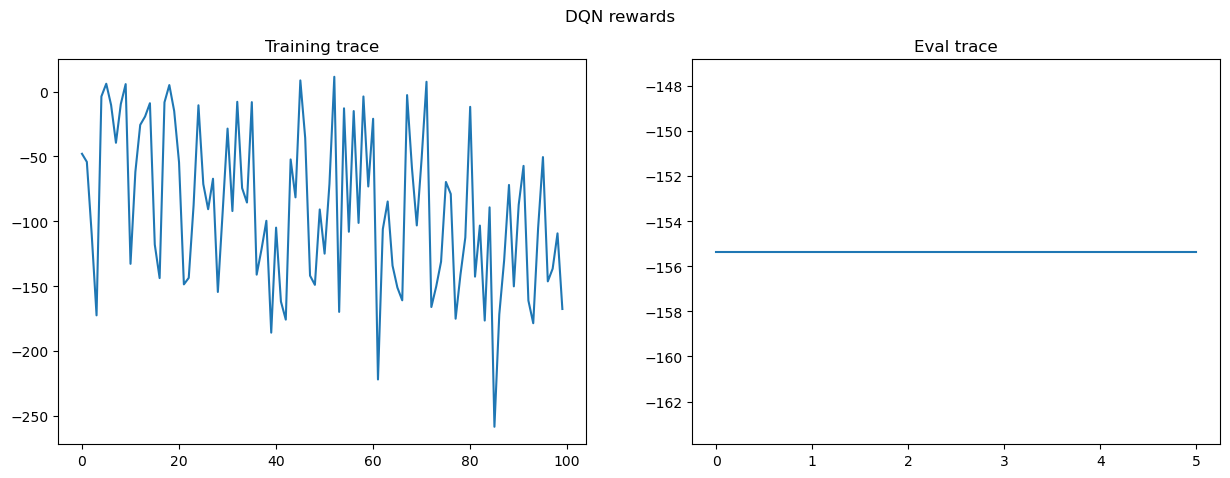

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))


ax[0].plot(tr_trace, label="training rewards")
ax[0].set_title("Training trace")

ax[1].plot(eval_trace_mean, label="eval mean reward")
ax[1].set_title("Eval trace")

fig.suptitle("DQN rewards")

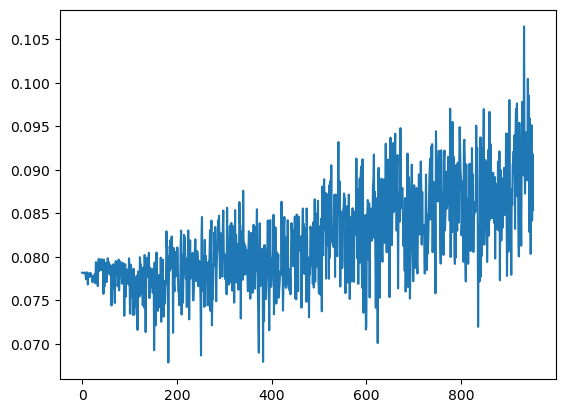

In [29]:
plt.plot(tr_losses)